# Adagrad

In [5]:
def sgd_adagrad(parameters, sqrs, lr):
    eps = 1e-10
    i = 0
    for param, sqr in zip(parameters, sqrs):
        sqr += param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div
        sqrs[i] = sqr
        i += 1

In [2]:
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32')
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [6]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_adagrad(net.parameters(), sqrs, 1e-2) # 学习率设为 0.01
        # 记录误差
        train_loss += loss.data[0]
        losses.append(loss.data[0])
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 1.780555
epoch: 1, Train Loss: 0.262189
epoch: 2, Train Loss: 0.198006
epoch: 3, Train Loss: 0.161873
epoch: 4, Train Loss: 0.137590
使用时间: 39.85541 s


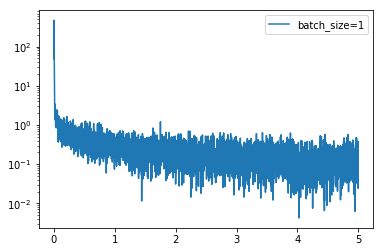

In [7]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='batch_size=1')
plt.legend(loc='best')

可以看到，我们能够将学习率设置得稍微大一点，参数更新迭代之后，学习率能够自适应地降低，所以开始的 loss 非常大，但是很快便降低下来了

当然 pytorch 也内置了 adagrad 的优化算法，只需要调用 `torch.optim.Adagrad()` 就可以了，下面是例子

In [3]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
 
optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data[0]
        losses.append(loss.data[0])
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 2.272687
epoch: 1, Train Loss: 0.244028
epoch: 2, Train Loss: 0.170324
epoch: 3, Train Loss: 0.134511
epoch: 4, Train Loss: 0.111336
使用时间: 46.50690 s
